In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import json
import numpy as np
import re
import pandas as pd
import heapq
from collections import defaultdict
from tqdm import tqdm
from google.colab import drive

In [3]:
def load_data():
    with open('/kaggle/input/trainingdata/train_data1.json', 'r') as file:
        data_train = json.load(file)

    with open('/kaggle/input/test-data/test_data1_final.json', 'r') as file:
        data_val = json.load(file)
    return data_train, data_val
data_train, data_val = load_data()
# print(data_train)

In [4]:
def train_json_to_list(data, language_pair):

    source_list, target_list, ids_list = [], [], []

    for lang_pair, lang_pair_data in data.items():
        if lang_pair == language_pair:
            for data_type, data_entries in lang_pair_data.items():
                for entry_id, entry_data in data_entries.items():
                    source = entry_data["source"]
                    target = entry_data["target"]

                    source_list.append(source)
                    target_list.append(target)
                    ids_list.append(entry_id)

    return source_list, target_list, ids_list


In [5]:
def val_json_to_list(data , language_pair):
  source_list, ids_list = [], []
  for lang_pair, lang_pair_data in data.items():
      if lang_pair == language_pair:
          for data_type, data_entries in lang_pair_data.items():
              for entry_id, entry_data in data_entries.items():
                  source = entry_data["source"]
                  source_list.append(source)
                  ids_list.append(entry_id)

  return source_list, ids_list

In [6]:
source_train_ben, target_train_ben , train_ids_ben  = train_json_to_list(data_train, "English-Bengali")
source_val_ben, val_ids_ben = val_json_to_list(data_val, "English-Bengali")

source_train_hin, target_train_hin, train_ids_hin = train_json_to_list(data_train, "English-Hindi")
source_val_hin, val_ids_hin = val_json_to_list(data_val, "English-Hindi")

print(source_val_ben[1])
print("\n")
print(source_val_hin[1])


The god Brahma was pleased with her penance but told her that she would have to marry the daitya Shankhachuda before she could marry Vishnu.


what is the address for the event scheduled on the first of january


In [7]:
def load_aug_csv(path, src_col, tgt_col):
    df = pd.read_csv(path)
    df = df[[src_col, tgt_col]].dropna().astype(str)
    df = df[(df[src_col].str.strip() != "") & (df[tgt_col].str.strip() != "")]
    return df[src_col].tolist(), df[tgt_col].tolist()

aug_source_train_hi, aug_target_train_hin = load_aug_csv("/kaggle/input/aug-data/en_hi_dataset_100k.csv", "english", "hindi")

aug_source_train_bn, aug_target_bn = load_aug_csv("/kaggle/input/aug-data/en_bn_dataset_100k.csv", "english", "bengali")

# English–Hindi
start_idx_hi = len(train_ids_hin)
train_ids_hin.extend([f"aug-hi-{i+start_idx_hi}" for i in range(len(aug_source_train_hi))])
source_train_hin.extend(aug_source_train_hi)
target_train_hin.extend(aug_target_train_hin)

# English–Bengali
start_idx_bn = len(train_ids_ben)
train_ids_ben.extend([f"aug-bn-{i+start_idx_bn}" for i in range(len(aug_source_train_bn))])
source_train_ben.extend(aug_source_train_bn)
target_train_ben.extend(aug_target_bn)

assert len(source_train_hin) == len(target_train_hin) == len(train_ids_hin)
assert len(source_train_ben) == len(target_train_ben) == len(train_ids_ben)

print(f"En–Hi train total: {len(source_train_hin)} (added {len(aug_source_train_hi)})")
print(f"En–Bn train total: {len(source_train_ben)} (added {len(aug_source_train_bn)})")

En–Hi train total: 180797 (added 100000)
En–Bn train total: 168849 (added 100000)


In [8]:
class Node:
    def __init__(self, token_id):
        self.token_id = token_id
        self.prev = None
        self.next = None

class BPETokenizer:
    def __init__(self):
        self.vocab = {}
        self.inverse_vocab = {}
        self.merges = {}
        self.token_to_id = {}
        self.id_to_token = {}

    def initialize_vocab(self):
        reserved = ["<PAD>", "<UNK>", "<SOS>", "<EOS>"]
        self.vocab = {i: tok for i, tok in enumerate(reserved)}
        self.inverse_vocab = {tok: i for i, tok in self.vocab.items()}
        return len(self.vocab)

    def build_corpus(self, text, next_token_id):
        words = [list(w) + ["</w>"] for w in text.strip().split()]
        corpus = []
        for w in words:
            head, prev = None, None
            for ch in w:
                if ch not in self.inverse_vocab:
                    self.vocab[next_token_id] = ch
                    self.inverse_vocab[ch] = next_token_id
                    next_token_id += 1
                node = Node(self.inverse_vocab[ch])
                if prev:
                    prev.next, node.prev = node, prev
                else:
                    head = node
                prev = node
            corpus.append(head)
        return corpus, next_token_id

    def count_pairs(self, corpus):
        pair_occurrences = defaultdict(set)
        for head in corpus:
            node = head
            while node and node.next:
                pair_occurrences[(node.token_id, node.next.token_id)].add(node)
                node = node.next
        return pair_occurrences

    def merge_pair(self, pair, new_id, pair_occurrences, heap):
        t1, t2 = pair
        new_tok = self.vocab[t1] + self.vocab[t2]
        self.vocab[new_id] = new_tok
        self.inverse_vocab[new_tok] = new_id
        affected = list(pair_occurrences[pair])
        pair_occurrences[pair].clear()
        for node in affected:
            if not node.next or node.token_id != t1 or node.next.token_id != t2:
                continue
            node.token_id = new_id
            removed = node.next
            node.next = removed.next
            if removed.next:
                removed.next.prev = node
            if node.prev:
                old = (node.prev.token_id, t1)
                pair_occurrences[old].discard(node.prev)
                new = (node.prev.token_id, node.token_id)
                pair_occurrences[new].add(node.prev)
                heapq.heappush(heap, (-len(pair_occurrences[new]), new))
            if node.next:
                old = (t2, node.next.token_id)
                pair_occurrences[old].discard(node)
                new = (node.token_id, node.next.token_id)
                pair_occurrences[new].add(node)
                heapq.heappush(heap, (-len(pair_occurrences[new]), new))

    def train(self, text, vocab_size=5000):
        next_id = self.initialize_vocab()
        corpus, next_id = self.build_corpus(text, next_id)
        pair_occurrences = self.count_pairs(corpus)
        heap = [(-len(nodes), pair) for pair, nodes in pair_occurrences.items()]
        heapq.heapify(heap)
        while len(self.vocab) < vocab_size and heap:
            freq, pair = heapq.heappop(heap)
            freq = -freq
            if freq == 0 or len(pair_occurrences[pair]) != freq:
                continue
            self.merges[pair] = next_id
            self.merge_pair(pair, next_id, pair_occurrences, heap)
            next_id += 1
        self.token_to_id = {tok: tid for tid, tok in self.vocab.items()}
        self.id_to_token = {tid: tok for tid, tok in self.vocab.items()}

    def tokenize(self, text):
        words = [list(w) + ["</w>"] for w in text.strip().split()]
        tokens = []
        for w in words:
            ids = [self.inverse_vocab.get(ch, self.token_to_id["<UNK>"]) for ch in w]
            merged = True
            while merged:
                merged, i = False, 0
                while i < len(ids) - 1:
                    pair = (ids[i], ids[i + 1])
                    if pair in self.merges:
                        ids[i] = self.merges[pair]
                        ids.pop(i + 1)
                        merged = True
                    else:
                        i += 1
            tokens.extend(ids)
        return tokens


    def decode(self, token_ids):
        specials = {self.token_to_id.get("<PAD>"), self.token_to_id.get("<UNK>"),
                    self.token_to_id.get("<SOS>"), self.token_to_id.get("<EOS>")}
        words, cur = [], []
        for tid in token_ids:
            if tid in specials:
                continue
            tok = self.id_to_token.get(tid, "<UNK>")
            if tok.endswith("</w>"):
                cur.append(tok[:-4])
                if cur:
                    words.append("".join(cur))
                cur = []
            else:
                cur.append(tok)
        if cur:
            words.append("".join(cur))
        return " ".join(words).strip()


In [9]:

def clean_text(text, lang="en"):
    """Cleans and normalizes text before tokenization."""
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[“”‘’]', '"', text)
    if lang == "hi":
        text = re.sub(r'[^\u0900-\u097F\s.,!?]', '', text)
    elif lang == "bn":
        text = re.sub(r'[^\u0980-\u09FF\s.,!?।]', '', text)
    else:
        text = re.sub(r'[^\w\s.,!?]', '', text)
        text = text.lower()
    return text

In [10]:
# bpe=BPETokenizer()
bpe=BPETokenizer()
#concatenatte all hindi and english text for tokenizer training also test vocab means sourse english,target hindi,target bengali,val source english
#sperately training is bad for most the cases 
bpe.train(" ".join([clean_text(s, "en") for s in source_train_hin] + 
                    [clean_text(t, "hi") for t in target_train_hin] +
                    [clean_text(s, "en") for s in source_train_ben] +
                    [clean_text(t, "bn") for t in target_train_ben] +
                    [clean_text(s, "en") for s in source_val_ben] +
                    [clean_text(s, "en") for s in source_val_hin]), vocab_size=40000)
print("bpe trained :")

bpe trained :


In [13]:
#Ensure special tokens are in the tokenizer vocab 
#Add special tokens if not present
#Adding special tokens to both tokenizers
#Initially I had two tokenizers for hindi and bengali but now using single tokenizer for both languages because of better vocabulary coverage for merged tokenizer training

for tokenizer in [bpe,bpe]:
    for t in ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]:
        if t not in tokenizer.token_to_id:
            new_id = len(tokenizer.token_to_id)
            tokenizer.token_to_id[t] = new_id
            tokenizer.id_to_token[new_id] = t

In [14]:
SEQ_LENGTH = 50
# Padding and encoding function
# Adds <SOS> and <EOS> tokens and pads/truncates to max_length 
# Returns list of token IDs
# eg: pad_encode(tokenizer, "Hello world", 10) and its output is [2, 15, 23, 3, 0, 0, 0, 0, 0, 0] assuming <SOS>=2, <EOS>=3, <PAD>=0, "Hello"=15, "world"=23
# Here, max_length includes <SOS> and <EOS> tokens
# So for a max_length of 10, the actual text can be up to 8 tokens long because of the two special tokens i,e <SOS> and <EOS>

def pad_encode(tokenizer, sent, max_length):
    sos = [tokenizer.token_to_id["<SOS>"]]
    eos = [tokenizer.token_to_id["<EOS>"]]
    pad = [tokenizer.token_to_id["<PAD>"]]
    encoded = tokenizer.tokenize(sent)
    if len(encoded) < max_length - 2:
        n_pads = max_length - 2 - len(encoded)
        return sos + encoded + eos + pad * n_pads
    else:
        return sos + encoded[:max_length - 2] + eos

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
# Custom Dataset class for translation data for our Translation Task
# It takes source and target tensors and implements __getitem__ and __len__ methods which return source-target pair at given index and length of dataset respectively
# This class can be used with PyTorch DataLoader for batching and shuffling data during training and evaluation and inference time 

class TranslationDataset(Dataset):
    def __init__(self, src_tensor, tgt_tensor):
        assert len(src_tensor) == len(tgt_tensor), \
            f"Source and target lengths differ: {len(src_tensor)} vs {len(tgt_tensor)}"
        self.src = src_tensor
        self.tgt = tgt_tensor

    def __getitem__(self, index):
        return self.src[index], self.tgt[index]

    def __len__(self):
        return len(self.src)

In [16]:

#encoding and padding the datasets
#for bengali
#en_train_encoded_ben=items of list of list where each inner list is token ids of a sentence
#de_train_encoded_ben=items of list of list where each inner list is token ids of a sentence
#en_val_encoded_ben=items of list of list where each inner list is token ids of a sentence
#de_val_encoded_ben=items of list of list where each inner list is token ids of a sentence


en_train_encoded_ben = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in source_train_ben]
de_train_encoded_ben = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in target_train_ben]
en_val_encoded_ben = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in source_val_ben]
de_val_encoded_ben = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in source_val_ben]
#for hindi
#en_train_encoded_hin=items of list of list where each inner list is token ids of a sentence
#de_train_encoded_hin=items of list of list where each inner list is token ids of a sentence
#en_val_encoded_hin=items of list of list where each inner list is token ids of a sentence
#de_val_encoded_hin=items of list of list where each inner list is token ids of a sentence

en_train_encoded_hin = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in source_train_hin]
de_train_encoded_hin = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in target_train_hin]
en_val_encoded_hin = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in source_val_hin]
de_val_encoded_hin = [pad_encode(bpe, sent, SEQ_LENGTH) for sent in source_val_hin]

#converting to numpy arrays then to tensors and creating dataloaders in dataoader function
train_x_ben = np.array(en_train_encoded_ben)
train_y_ben = np.array(de_train_encoded_ben)
test_x_ben = np.array(en_val_encoded_ben)
test_y_ben = np.array(de_val_encoded_ben)
#for hindi
train_x_hin = np.array(en_train_encoded_hin)
train_y_hin = np.array(de_train_encoded_hin)
test_x_hin = np.array(en_val_encoded_hin)
test_y_hin = np.array(de_val_encoded_hin)
BATCH_SIZE =32
#for bengaki
train_ds_ben = TranslationDataset(torch.from_numpy(train_x_ben), torch.from_numpy(train_y_ben))
test_ds_ben = TranslationDataset(torch.from_numpy(test_x_ben), torch.from_numpy(test_y_ben))
train_dl_ben = DataLoader(train_ds_ben, shuffle=True, batch_size=BATCH_SIZE, drop_last=False)
test_dl_ben = DataLoader(test_ds_ben, shuffle=False, batch_size=BATCH_SIZE)

#for hindi
train_ds_hin = TranslationDataset(torch.from_numpy(train_x_hin), torch.from_numpy(train_y_hin))
test_ds_hin = TranslationDataset(torch.from_numpy(test_x_hin), torch.from_numpy(test_y_hin))
train_dl_hin = DataLoader(train_ds_hin, shuffle=True, batch_size=BATCH_SIZE, drop_last=False)
test_dl_hin = DataLoader(test_ds_hin, shuffle=False, batch_size=BATCH_SIZE)


In [17]:

#Same as Assignemnt 5 calss configuration for Transformer model 
class Config:
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PAD_IDX = bpe.token_to_id["<PAD>"]
VOCAB_SIZE = len(bpe.token_to_id)

D_MODEL = 256
N_HEADS = 8
NUM_LAYERS = 4
D_FF = 1024
DROPOUT = 0.1
NUM_EPOCHS = 20
LR = 5e-4
#Forr bengali 
config_ben = Config()
config_ben.D_MODEL = D_MODEL
config_ben.N_HEADS = N_HEADS
config_ben.NUM_ENCODER_LAYERS = NUM_LAYERS
config_ben.NUM_DECODER_LAYERS = NUM_LAYERS
config_ben.D_FF = D_FF
config_ben.DROPOUT = DROPOUT
config_ben.SEQ_LENGTH = SEQ_LENGTH
config_ben.PAD_IDX = PAD_IDX
config_ben.VOCAB_SRC_SIZE = VOCAB_SIZE
config_ben.VOCAB_TGT_SIZE = VOCAB_SIZE
config_ben.DEVICE = device
config_ben.NUM_EPOCHS = NUM_EPOCHS
config_ben.LEARNING_RATE = LR
config_ben.USE_MULTI_GPU = False
config_ben.MODEL_SAVE_PATH = "transformer_en_bn.pt"

config_hin = Config()
config_hin.D_MODEL = D_MODEL
config_hin.N_HEADS = N_HEADS
config_hin.NUM_ENCODER_LAYERS = NUM_LAYERS
config_hin.NUM_DECODER_LAYERS = NUM_LAYERS
config_hin.D_FF = D_FF
config_hin.DROPOUT = DROPOUT
config_hin.SEQ_LENGTH = SEQ_LENGTH
config_hin.PAD_IDX = PAD_IDX
config_hin.VOCAB_SRC_SIZE = VOCAB_SIZE
config_hin.VOCAB_TGT_SIZE = VOCAB_SIZE
config_hin.DEVICE = device
config_hin.NUM_EPOCHS = NUM_EPOCHS
config_hin.LEARNING_RATE = LR
config_hin.USE_MULTI_GPU = False
config_hin.MODEL_SAVE_PATH = "transformer_en_hi.pt"


device is: cuda
vocab size: 40000

Train en-bn 

start training :
Adam optimizer with LR: 0.0005
Training for 20 epochs



Epoch 01/20 | 7m 59s
  train Loss: 2.878 | ppl:  17.773
  valid Loss: 8.492 | ppl: 4873.611 (best model saved)



Epoch 02/20 | 7m 57s
  train Loss: 2.508 | ppl:  12.278
  valid Loss: 8.082 | ppl: 3236.743 (best model saved)



Epoch 03/20 | 7m 55s
  train Loss: 2.414 | ppl:  11.183
  valid Loss: 8.080 | ppl: 3228.445 (best model saved)



Epoch 04/20 | 7m 53s
  train Loss: 2.354 | ppl:  10.532
  valid Loss: 8.028 | ppl: 3064.356 (best model saved)



Epoch 05/20 | 7m 52s
  train Loss: 2.313 | ppl:  10.109
  valid Loss: 8.050 | ppl: 3134.456



Epoch 06/20 | 7m 52s
  train Loss: 2.283 | ppl:   9.801
  valid Loss: 7.918 | ppl: 2746.558 (best model saved)



Epoch 07/20 | 7m 52s
  train Loss: 2.259 | ppl:   9.572
  valid Loss: 7.920 | ppl: 2752.763



Epoch 08/20 | 7m 52s
  train Loss: 2.240 | ppl:   9.397
  valid Loss: 7.849 | ppl: 2563.546 (best model saved)



Epoch 09/20 | 7m 52s
  train Loss: 2.224 | ppl:   9.248
  valid Loss: 7.894 | ppl: 2681.226



Epoch 10/20 | 7m 52s
  train Loss: 2.212 | ppl:   9.132
  valid Loss: 7.923 | ppl: 2760.825



Epoch 11/20 | 7m 51s
  train Loss: 2.200 | ppl:   9.029
  valid Loss: 7.960 | ppl: 2863.690



Epoch 12/20 | 7m 50s
  train Loss: 2.191 | ppl:   8.942
  valid Loss: 7.706 | ppl: 2221.582 (best model saved)



Epoch 13/20 | 7m 50s
  train Loss: 2.182 | ppl:   8.861
  valid Loss: 7.770 | ppl: 2367.467



Epoch 14/20 | 7m 50s
  train Loss: 2.175 | ppl:   8.798
  valid Loss: 7.731 | ppl: 2277.736



Epoch 15/20 | 7m 50s
  train Loss: 2.168 | ppl:   8.739
  valid Loss: 7.855 | ppl: 2578.195



Epoch 16/20 | 7m 50s
  train Loss: 2.161 | ppl:   8.680
  valid Loss: 7.704 | ppl: 2216.356 (best model saved)



Epoch 17/20 | 7m 50s
  train Loss: 2.155 | ppl:   8.632
  valid Loss: 7.611 | ppl: 2020.440 (best model saved)



Epoch 18/20 | 7m 50s
  train Loss: 2.151 | ppl:   8.591
  valid Loss: 7.560 | ppl: 1919.910 (best model saved)



Epoch 19/20 | 7m 50s
  train Loss: 2.146 | ppl:   8.548
  valid Loss: 7.698 | ppl: 2204.859



Epoch 20/20 | 7m 50s
  train Loss: 2.142 | ppl:   8.513
  valid Loss: 7.621 | ppl: 2040.371

Training finished. Best valid loss: 7.560


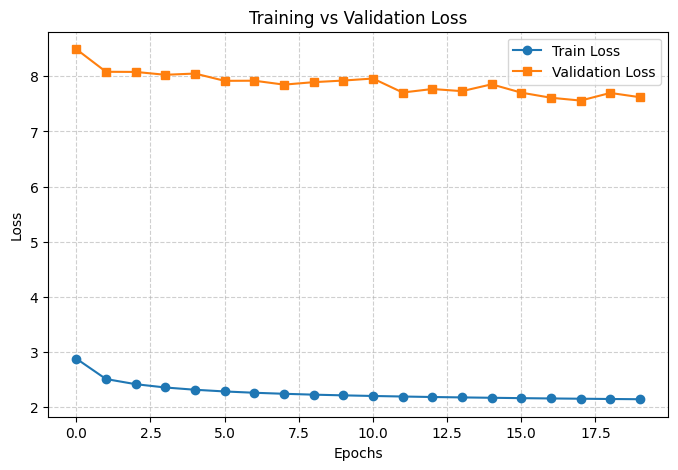


 gen ben transalation


Translating: 100%|██████████| 615/615 [04:58<00:00,  2.06batch/s]


saved Ben predictions to answer_ben.csv

 Train en-hi 

start training :
Adam optimizer with LR: 0.0005
Training for 20 epochs



Epoch 01/20 | 8m 33s
  train Loss: 3.296 | ppl:  27.015
  valid Loss: 8.006 | ppl: 2999.447 (best model saved)



Epoch 02/20 | 8m 31s
  train Loss: 2.812 | ppl:  16.651
  valid Loss: 7.587 | ppl: 1972.946 (best model saved)



Epoch 03/20 | 8m 29s
  train Loss: 2.686 | ppl:  14.679
  valid Loss: 7.187 | ppl: 1322.326 (best model saved)



Epoch 04/20 | 8m 27s
  train Loss: 2.610 | ppl:  13.601
  valid Loss: 7.250 | ppl: 1408.615



Epoch 05/20 | 8m 27s
  train Loss: 2.556 | ppl:  12.882
  valid Loss: 7.095 | ppl: 1205.411 (best model saved)



Epoch 06/20 | 8m 27s
  train Loss: 2.516 | ppl:  12.381
  valid Loss: 6.935 | ppl: 1027.249 (best model saved)



Epoch 07/20 | 8m 27s
  train Loss: 2.484 | ppl:  11.990
  valid Loss: 7.125 | ppl: 1242.173



Epoch 08/20 | 8m 27s
  train Loss: 2.458 | ppl:  11.681
  valid Loss: 7.073 | ppl: 1179.747



Epoch 09/20 | 8m 27s
  train Loss: 2.437 | ppl:  11.436
  valid Loss: 6.811 | ppl: 907.365 (best model saved)



Epoch 10/20 | 8m 27s
  train Loss: 2.418 | ppl:  11.226
  valid Loss: 6.779 | ppl: 878.806 (best model saved)



Epoch 11/20 | 8m 27s
  train Loss: 2.403 | ppl:  11.056
  valid Loss: 6.746 | ppl: 850.310 (best model saved)



Epoch 12/20 | 8m 26s
  train Loss: 2.389 | ppl:  10.905
  valid Loss: 6.803 | ppl: 900.940



Epoch 13/20 | 8m 26s
  train Loss: 2.377 | ppl:  10.773
  valid Loss: 6.689 | ppl: 803.845 (best model saved)



Epoch 14/20 | 8m 26s
  train Loss: 2.367 | ppl:  10.664
  valid Loss: 6.727 | ppl: 834.982



Epoch 15/20 | 8m 26s
  train Loss: 2.358 | ppl:  10.565
  valid Loss: 6.660 | ppl: 780.596 (best model saved)



Epoch 16/20 | 8m 26s
  train Loss: 2.349 | ppl:  10.478
  valid Loss: 6.734 | ppl: 840.665



Epoch 17/20 | 8m 26s
  train Loss: 2.342 | ppl:  10.405
  valid Loss: 6.576 | ppl: 717.474 (best model saved)



Epoch 18/20 | 8m 26s
  train Loss: 2.336 | ppl:  10.342
  valid Loss: 6.615 | ppl: 746.497



Epoch 19/20 | 8m 26s
  train Loss: 2.330 | ppl:  10.279
  valid Loss: 6.484 | ppl: 654.598 (best model saved)



Epoch 20/20 | 8m 26s
  train Loss: 2.325 | ppl:  10.222
  valid Loss: 6.571 | ppl: 713.782

Training finished. Best valid loss: 6.484


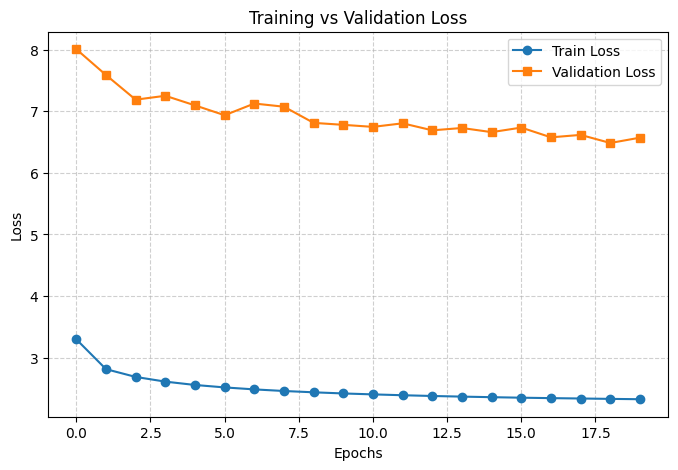


gen en-hi transaltion


Translating: 100%|██████████| 722/722 [05:52<00:00,  2.05batch/s]

saved Hin predictions to answer_hi.csv


In [21]:
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
#Approach follows "Attention is all you need" paper with pre-norm transformer architecture
"""
Detailed Approach is below whatever I have impelemted 
It is a standard Transformer model with Encoder-Decoder architecture using multi-head attention and position-wise feed-forward networks.
with 8 attention heads, 512-dimensional model, 1024-dimensional feed-forward layers, and dropout for regularization.
1. Positional Encoding: Adds positional information to input embeddings using sine and cosine functions.
2. Multi-Head Attention: Implements scaled dot-product attention with multiple heads for capturing different representation subspaces.
3. Position-wise Feed-Forward Network: Two linear layers with ReLU activation in between, applied to each position separately.
4. Encoder Layer: Consists of multi-head self-attention followed by a feed-forward network, both with pre-layer normalization and residual connections.
5. Decoder Layer: Similar to the encoder layer but includes an additional cross-attention mechanism that attends to the encoder's output.
6. Encoder: Stacks multiple encoder layers, applies embedding and positional encoding to the input sequence.
7. Decoder: Stacks multiple decoder layers, applies embedding and positional encoding to the target sequence.
8. Transformer: Combines the encoder and decoder, includes methods for creating source and target masks, and a final linear layer to project decoder outputs to vocabulary size.
 Lets wak through the a example step by step:
 input sentence "Hello I am student in CS779 course ,I love NLP "
targtet sentence : "नमस्ते मैं CS779 पाठ्यक्रम में छात्र हूँ , मुझे NLP पसंद है "
# 1. Input Embedding and Positional Encoding:
The input sentence is tokenized and converted into embeddings. Positional encoding is added to these embeddings to provide information about the position of each token in the sequence.
input embeddings: [B, S, d_model]
positional encoding: [1, S, d_model]
# 2. Encoder:
The encoder processes the input embeddings through multiple layers. Each layer consists of multi-head self-attention and a feed-forward network, both with residual connections and layer normalization.
encoder output: [B, S, d_model]
# 3. Target Embedding and Positional Encoding:
The target sentence is also tokenized and converted into embeddings. Positional encoding is added to these embeddings.
target embeddings: [B, T, d_model]
positional encoding: [1, T, d_model]
# 4. Decoder:
The decoder processes the target embeddings through multiple layers. Each layer consists of masked multi-head self-attention, cross-attention with the encoder output, and a feed-forward network, all with residual connections and layer normalization.
decoder output: [B, T, d_model]
# 5. Final Linear Layer:
The output from the decoder is passed through a final linear layer to project it to the vocabulary size, producing logits for each token in the target vocabulary.

\
"""
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout_rate=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)

        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # [1, max_len, d_model]

    def forward(self, x):
        # x: [B, T, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    """
    Multi-head scaled dot-product attention.
    mask: boolean, broadcastable to [B, 1, T_q, T_k]; True=keep, False=mask.
    """
    def __init__(self, d_model, num_heads, dropout_rate=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model   = d_model
        self.num_heads = num_heads
        self.d_k       = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(dropout_rate)

    def _split_heads(self, x):
        # x: [B, T, d_model] -> [B, h, T, d_k]
        B, T, _ = x.size()
        x = x.view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        return x

    def _combine_heads(self, x):
        # x: [B, h, T, d_k] -> [B, T, d_model]
        B, h, T, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(B, T, h * d_k)

    def forward(self, query, key, value, mask=None):
        # Q,K,V projections
        Q = self.W_q(query)   # [B, T_q, d_model]
        K = self.W_k(key)     # [B, T_k, d_model]
        V = self.W_v(value)   # [B, T_k, d_model]

        Q = self._split_heads(Q)  # [B, h, T_q, d_k]
        K = self._split_heads(K)  # [B, h, T_k, d_k]
        V = self._split_heads(V)  # [B, h, T_k, d_k]

        scores = (Q @ K.transpose(-2, -1)) / math.sqrt(self.d_k)  # [B, h, T_q, T_k]

        if mask is not None:
            # mask: True=keep, False=mask
            # broadcast to [B, 1, T_q, T_k] then [B, h, T_q, T_k]
            if mask.dim() == 4:
                mask_expanded = mask
            elif mask.dim() == 3:
                mask_expanded = mask.unsqueeze(1)
            else:
                raise ValueError("mask must have 3 or 4 dims")
            scores = scores.masked_fill(~mask_expanded, float('-inf'))

        attn = torch.softmax(scores, dim=-1)           # [B, h, T_q, T_k]
        attn = self.dropout(attn)
        context = attn @ V                              # [B, h, T_q, d_k]

        context = self._combine_heads(context)          # [B, T_q, d_model]
        out = self.W_o(context)                         # [B, T_q, d_model]
        return out

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout_rate=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(d_ff, d_model),
        )

    def forward(self, x):
        return self.net(x)

class EncoderLayer(nn.Module):
    """
    Single Transformer
    B,S, d_model= batch size, seq len, model dim
    encoder layer: x + MHA(LN(x)) + FFN(LN(x))
    """
    def __init__(self, d_model, num_heads, d_ff, dropout_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout_rate)
        self.drop1 = nn.Dropout(dropout_rate)

        self.norm2 = nn.LayerNorm(d_model)
        self.ffn   = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.drop2 = nn.Dropout(dropout_rate)

    def forward(self, x, src_mask):
        # self-attn
        y = self.norm1(x)
        attn_out = self.self_attn(y, y, y, mask=src_mask)  # [B,S,d_model]
        x = x + self.drop1(attn_out)
        # ffn
        y = self.norm2(x)
        ffn_out = self.ffn(y)
        x = x + self.drop2(ffn_out)
        return x

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout_rate, max_seq_len):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout_rate, max_len=max_seq_len)
        self.dropout = nn.Dropout(dropout_rate)
        self.layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout_rate) for _ in range(num_layers)]
        )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, src, src_mask):
        # src: [B,S]
        x = self.embedding(src) * math.sqrt(self.d_model)  # [B,S,d_model]
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return self.norm(x)  # [B,S,d_model]
    
class DecoderLayer(nn.Module):
    """
    Single Transformer decoder layer:
      1) masked self-attn on tgt
      2) cross-attn on encoder output
      3) position-wise FFN

    """
    def __init__(self, d_model, num_heads, d_ff, dropout_rate):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout_rate)
        self.norm1     = nn.LayerNorm(d_model)
        self.dropout1  = nn.Dropout(dropout_rate)

        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout_rate)
        self.norm2      = nn.LayerNorm(d_model)
        self.dropout2   = nn.Dropout(dropout_rate)

        self.ffn    = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.norm3  = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout_rate)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        # 1) masked self-attn on x
        y = self.norm1(x)
        self_attn_out = self.self_attn(y, y, y, mask=tgt_mask)
        x = x + self.dropout1(self_attn_out)

        # 2) cross-attn: Q from decoder, K/V from encoder
        y = self.norm2(x)
        cross_attn_out = self.cross_attn(y, encoder_output, encoder_output, mask=src_mask)
        x = x + self.dropout2(cross_attn_out)

        # 3) feed-forward
        y = self.norm3(x)
        ffn_out = self.ffn(y)
        x = x + self.dropout3(ffn_out)

        return x

class Decoder(nn.Module):
    """
    Transformer decoder: stack of 4 decoder layers.
    B=batch size, T=target seq len, S=source seq len, d_model=model dim
    Inputs:
      x: [B,T] (target indices)
      encoder_output: [B,S,d_model]
      src_mask: [B,1,1,S]
      tgt_mask: [B,1,T,T]
    Outputs:
        out: [B,T,d_model]
    here we are using 4 layers in decoder as Block of transformer,each block is made of multi head attention and feed forward network

    """
    def __init__(self, vocab_size, d_model, num_layers, num_heads,
                 d_ff, dropout_rate, max_seq_len):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout_rate, max_len=max_seq_len)
        self.layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout_rate) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        # x: [B,T] (target indices)
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)  # [B,T,d_model]


class Transformer(nn.Module):
    """ here 
    B=batch size, S=source seq len, T_input=target seq len (input to decoder), d=model dim, V=vocab size
    encoder-decoder + final linear to vocab.
    Inputs: src: [B,S]; tgt: [B,T_input] (shifted right)
    Outputs: logits: [B,T_input,vocab_tgt_size]
    """
    def __init__(self, config, vocab_src_size, vocab_tgt_size, src_pad_idx, tgt_pad_idx):
        super().__init__()
        self.config = config
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx

        self.encoder = Encoder(
            vocab_size=vocab_src_size,
            d_model=config.D_MODEL,
            num_layers=config.NUM_ENCODER_LAYERS,
            num_heads=config.N_HEADS,
            d_ff=config.D_FF,
            dropout_rate=config.DROPOUT,
            max_seq_len=config.SEQ_LENGTH + 20
        )

        self.decoder = Decoder(
            vocab_size=vocab_tgt_size,
            d_model=config.D_MODEL,
            num_layers=config.NUM_DECODER_LAYERS,
            num_heads=config.N_HEADS,
            d_ff=config.D_FF,
            dropout_rate=config.DROPOUT,
            max_seq_len=config.SEQ_LENGTH + 20
        )

        self.final_linear = nn.Linear(config.D_MODEL, vocab_tgt_size)
        self._initialize_weights()

    def _initialize_weights(self):
        """we have used xavier uniform initialization for weights of all layers,xavier initialization helps in better convergence of deep networks 
        xavier instialisation for a eaxample weight matrix W of size (in_features, out_features): 
        """
        for name, p in self.named_parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        if hasattr(self.encoder, 'embedding'):
            nn.init.xavier_uniform_(self.encoder.embedding.weight)
        if hasattr(self.decoder, 'embedding'):
            nn.init.xavier_uniform_(self.decoder.embedding.weight)

    def create_src_mask(self, src):
        """
        B=batch size, S=source seq len
        pad_idx: padding token index which is equal to 0 in our case in vocabulary
        src: [B,S]
        keep tokens != pad_idx
        """
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)  # [B,1,1,S]
        return src_mask

    def create_tgt_mask(self, tgt):
        """
        B=batch size, T=target seq len
         tgt: [B,T]
        here we are creating target mask for decoder self attention which is combination of padding mask and look ahead mask which prevent the decoder from attending to future tokens
        which helps in auto regressive generation at the  inference time 
        """
        B, T = tgt.shape
        tgt_pad_mask = (tgt != self.tgt_pad_idx).unsqueeze(1).unsqueeze(2)  # [B,1,1,T]

        look_ahead = torch.triu(
            torch.ones((1, 1, T, T), device=tgt.device), diagonal=1
        ) == 0  # True in allowed positions

        tgt_mask = tgt_pad_mask & look_ahead
        return tgt_mask

    def forward(self, src, tgt):
        """
        B=batch size, S=source seq len, T_input=target seq len (input to decoder), V=vocab size
        src: [B,S]; tgt: [B,T_input] (shifted right)
        returns logits: [B,T_input,vocab_tgt_size]
        """
        src_mask = self.create_src_mask(src)
        tgt_mask = self.create_tgt_mask(tgt)

        enc_out = self.encoder(src, src_mask)                             # [B,S,d]
        dec_out = self.decoder(tgt, enc_out, src_mask, tgt_mask)          # [B,T,d]
        out = self.final_linear(dec_out)                                  # [B,T,V]
        return out

def train_fn(model, dataloader, optimizer, criterion, config):
    model.train()
    epoch_loss = 0.0
    for batch in tqdm(dataloader, desc="Training", leave=False):
        src = batch[0].to(config.DEVICE)  # [B,S]
        tgt = batch[1].to(config.DEVICE)  # [B,S]
        optimizer.zero_grad()

        # teacher forcing by shifting
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        logits = model(src, tgt_input)  # [B,T-1,V]
        logits_flat = logits.reshape(-1, logits.size(-1))
        tgt_flat = tgt_output.reshape(-1)

        loss = criterion(logits_flat, tgt_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def evaluate_fn(model, dataloader, criterion, config):
    model.eval()
    epoch_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            src = batch[0].to(config.DEVICE)
            tgt = batch[1].to(config.DEVICE)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            logits = model(src, tgt_input)
            logits_flat = logits.reshape(-1, logits.size(-1))
            tgt_flat = tgt_output.reshape(-1)
            loss = criterion(logits_flat, tgt_flat)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)


def epoch_time(start_time, end_time):
    time_taken = end_time - start_time
    epoch_mins = int(time_taken // 60)
    epoch_secs = int(time_taken % 60)
    return epoch_mins, epoch_secs


def train(config, train_dataloader, val_dataloader):
    print("\nstart training :")

    model = Transformer(
        config=config,
        vocab_src_size=config.VOCAB_SRC_SIZE,
        vocab_tgt_size=config.VOCAB_TGT_SIZE,
        src_pad_idx=config.PAD_IDX,
        tgt_pad_idx=config.PAD_IDX
    )


    model = model.to(config.DEVICE)
    total_paarmters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"total tarinnable parameter :{total_paarmters}")

    print(f"Adam optimizer with LR: {config.LEARNING_RATE}")
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-5)
    try:
        criterion = nn.CrossEntropyLoss(ignore_index=config.PAD_IDX, label_smoothing=0.1)
    except TypeError:
        criterion = nn.CrossEntropyLoss(ignore_index=config.PAD_IDX)

    best_valid_loss = float('inf')
    print(f"Training for {config.NUM_EPOCHS} epochs")

    for epoch in range(config.NUM_EPOCHS):
        start_time = time.time()

        train_loss = train_fn(model, train_dataloader, optimizer, criterion, config)
        valid_loss = evaluate_fn(model, val_dataloader, criterion, config)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # if valid_loss < best_valid_loss:
        #     best_valid_loss = valid_loss
        #     if isinstance(model, nn.DataParallel):
        #         torch.save(model.module.state_dict(), config.MODEL_SAVE_PATH)
        #     else:
        #         torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
        #     status = " (best model saved)"
        # else:
        #     status = ""

        print(f"\nEpoch {epoch+1:02}/{config.NUM_EPOCHS} | {epoch_mins}m {epoch_secs}s")
        print(f"  train Loss: {train_loss:.3f} | ppl: {math.exp(train_loss):7.3f}")

    print(f"\nTraining end : {best_valid_loss:.3f}")

@torch.no_grad()
def translate_transformer(model, dataloader, tokenizer, max_len=50, device=None):
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    SOS = tokenizer.token_to_id["<SOS>"]
    EOS = tokenizer.token_to_id["<EOS>"]
    PAD = tokenizer.token_to_id["<PAD>"]

    preds = []

    for src, _ in tqdm(dataloader, desc="Translating", unit="batch"):
        src = src.to(device)
        B = src.size(0)

        # initial target: [SOS]
        ys = torch.full((B, 1), SOS, dtype=torch.long, device=device)

        for _ in range(max_len - 1):
            src_mask = model.create_src_mask(src)
            tgt_mask = model.create_tgt_mask(ys)

            enc_out = model.encoder(src, src_mask)
            dec_out = model.decoder(ys, enc_out, src_mask, tgt_mask)
            logits = model.final_linear(dec_out[:, -1, :])  # last timestep: [B,V]

            next_ids = logits.argmax(-1, keepdim=True)      # [B,1]
            ys = torch.cat([ys, next_ids], dim=1)          # append token

        # convert ids -> text (drop SOS/EOS/PAD)
        for seq in ys:
            seq_ids = [i.item() for i in seq if i.item() not in (SOS, EOS, PAD)]
            preds.append(tokenizer.decode(seq_ids))
    return preds



# print("device ", device)
# print("vocab size:", VOCAB_SIZE)

# val_dl_ben = test_dl_ben
# val_dl_hin = test_dl_hin


# print("\nTrain en-bn ")
# model_ben = run_training(config_ben, train_dl_ben, val_dl_ben)

# print("\ngen en-bn translations")
# preds_ben = translate_transformer(model_ben, test_dl_ben, bpe, max_len=SEQ_LENGTH, device=device)
# df_ben = pd.DataFrame({"ID": val_ids_ben, "Translation": preds_ben})
# df_ben.to_csv("answer_ben.csv", index=False)
# print("saved Ben predictions to answer_ben.csv")


# print("\nTrain en-hi ")
# model_hin = run_training(config_hin, train_dl_hin, val_dl_hin)

# print("\ngen en-hi translations")
# preds_hin = translate_transformer(model_hin, test_dl_hin, bpe, max_len=SEQ_LENGTH, device=device)
# df_hin = pd.DataFrame({"ID": val_ids_hin, "Translation": preds_hin})
# df_hin.to_csv("answer_hi.csv", index=False)
# print("saved Hin predictions to answer_hi.csv")


print("\nTrain en-bn ")
model_ben = run_training(config_ben, train_dl_ben, val_dl_ben)

print("\ngen en-bn translations")
preds_ben = translate_transformer(model_ben, test_dl_ben, bpe, max_len=SEQ_LENGTH, device=device)
df_ben = pd.DataFrame({"ID": val_ids_ben, "Translation": preds_ben})
df_ben.to_csv("answer_ben.csv", index=False)
print("saved Ben predictions to answer_ben.csv")


print("\nTrain en-hi ")
model_hin = run_training(config_hin, train_dl_hin, val_dl_hin)

print("\ngen en-hi translations")
preds_hin = translate_transformer(model_hin, test_dl_hin, bpe, max_len=SEQ_LENGTH, device=device)
df_hin = pd.DataFrame({"ID": val_ids_hin, "Translation": preds_hin})
df_hin.to_csv("answer_hi.csv", index=False)
print("saved Hin predictions to answer_hi.csv")


In [22]:
print("\nCreating final submission file")
import pandas as pd

df_ben = pd.read_csv("/kaggle/working/answer_ben.csv")
df_hin = pd.read_csv("/kaggle/working/answer_hi.csv")
combined_data = pd.concat([df_ben, df_hin], axis=0, ignore_index=True)

with open("/kaggle/working/answer.csv", "w") as f:
    f.write("ID\tTranslation\n")
    for i in range(combined_data.shape[0]):
        f.write(f"{combined_data['ID'][i]}\t{combined_data['Translation'][i]}\n")

print("Final submission file created → answer.csv")
print(f"Total rows: {combined_data.shape[0] + 1} (including header)")  # +1 for header
print(f"Bengali entries: {len(df_ben)}")
print(f"Hindi entries: {len(df_hin)}")


Creating final submission file
Final submission file created → answer.csv
Total rows: 42758 (including header)
Bengali entries: 19672
Hindi entries: 23085
